<a href="https://colab.research.google.com/github/MirudulaShri260302/VLM-Anomaly-Detection/blob/main/Anomaly_detection_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/datasets/mvtec_ad"
print("Dataset root:", DATA_ROOT)
!ls $DATA_ROOT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset root: /content/drive/MyDrive/datasets/mvtec_ad
bottle	 carpet    leather	pill	    tile	wood
cable	 grid	   license.txt	readme.txt  toothbrush	zipper
capsule  hazelnut  metal_nut	screw	    transistor


In [ ]:
!pip install open_clip_torch timm scikit-image matplotlib tqdm einops opencv-python pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import open_clip
from skimage import io
from tqdm import tqdm
from PIL import Image


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess, _ = open_clip.create_model_and_transforms(
    'ViT-B-16', pretrained='openai'
)
tokenizer = open_clip.get_tokenizer('ViT-B-16')
model.to(device).eval()

print("Model loaded on:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Model loaded on: cpu


In [ ]:
normal_prompts = [
    "a photo of a normal {}",
    "a cropped photo of a normal {}",
    "a bright photo of a normal {}",
    "a clean photo of a normal {}",
]

anomaly_prompts = [
    "a photo of a defective {}",
    "a cropped photo of a defective {}",
    "a damaged {}",
    "a broken {}",
    "a corrupted {}",
]


In [ ]:
def encode_text_prompts(prompts, category):
    texts = [p.format(category) for p in prompts]
    tokens = tokenizer(texts).to(device)
    return model.encode_text(tokens).detach()


In [ ]:
def load_and_preprocess(path):
    img = io.imread(path)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    img_tensor = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)
    return img, img_tensor


In [ ]:
def anomaly_score(img_tensor, normal_texts, anomaly_texts):
    with torch.no_grad():
        image_feat = model.encode_image(img_tensor)

        sim_normal = torch.cosine_similarity(image_feat, normal_texts).mean()
        sim_anomaly = torch.cosine_similarity(image_feat, anomaly_texts).mean()

    score = (sim_anomaly - sim_normal).item()
    return score


In [ ]:
category = "bottle"

normal_texts = encode_text_prompts(normal_prompts, category)
anomaly_texts = encode_text_prompts(anomaly_prompts, category)

test_dir = f"{DATA_ROOT}/{category}/test"
good_dir = f"{test_dir}/good"

print("Testing category:", category)


Testing category: bottle


In [ ]:
scores = []

for defect_type in os.listdir(test_dir):
    defect_path = os.path.join(test_dir, defect_type)
    for img_name in os.listdir(defect_path):
        img_path = os.path.join(defect_path, img_name)
        img, tensor = load_and_preprocess(img_path)
        score = anomaly_score(tensor, normal_texts, anomaly_texts)
        scores.append((img_path, defect_type, score))

scores[:5]


[('/content/drive/MyDrive/datasets/mvtec_ad/bottle/test/broken_large/000.png',
  'broken_large',
  -0.0027337074279785156),
 ('/content/drive/MyDrive/datasets/mvtec_ad/bottle/test/broken_large/018.png',
  'broken_large',
  -0.0004133284091949463),
 ('/content/drive/MyDrive/datasets/mvtec_ad/bottle/test/broken_large/009.png',
  'broken_large',
  -0.0037499964237213135),
 ('/content/drive/MyDrive/datasets/mvtec_ad/bottle/test/broken_large/011.png',
  'broken_large',
  -0.013920456171035767),
 ('/content/drive/MyDrive/datasets/mvtec_ad/bottle/test/broken_large/004.png',
  'broken_large',
  0.012532949447631836)]

In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [0 if d=='good' else 1 for _, d, _ in scores]
y_score = [s for _,_,s in scores]

auc = roc_auc_score(y_true, y_score)
print("AUROC for", category, "=", round(auc, 4))


AUROC for bottle = 0.919


In [ ]:
import torch.nn.functional as F
from PIL import Image

def generate_segmentation_map(img, img_tensor, anomaly_texts):
    with torch.no_grad():
        img_feat = model.encode_image(img_tensor)

        H, W = img.shape[:2]
        heatmap = np.zeros((H, W))

        for y in range(0, H, 32):
            for x in range(0, W, 32):
                patch = img[y:y+32, x:x+32]
                if patch.shape[0] < 32 or patch.shape[1] < 32:
                    continue

                patch_tensor = preprocess(Image.fromarray(patch)).unsqueeze(0).to(device)
                patch_feat = model.encode_image(patch_tensor)

                score = torch.cosine_similarity(patch_feat, anomaly_texts).mean().item()
                heatmap[y:y+32, x:x+32] = score

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    return heatmap


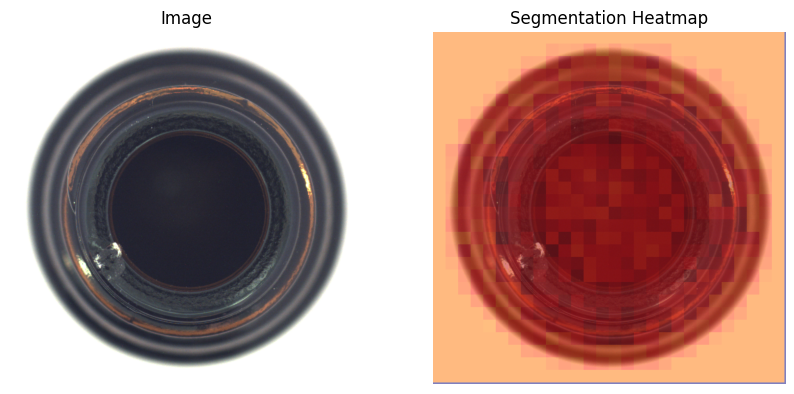

In [ ]:
sample_good = f"{DATA_ROOT}/{category}/test/broken_small/000.png"  # change to any anomaly img
img = io.imread(sample_good)
img_tensor = preprocess(Image.fromarray(img)).unsqueeze(0).to(device)

heatmap = generate_segmentation_map(img, img_tensor, anomaly_texts)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Segmentation Heatmap")
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()
